# <div align="center">  
# Gait Sequence Detection

## Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

from kielmat.datasets import mobilised
from kielmat.modules.gsd import ParaschivIonescuGaitSequenceDetection
from kielmat.config import cfg_colors

In [7]:
import pandas as pd

## Insert Raw IMU Data

In [8]:
# Insert file path
csv_file_path = 'IMUS1.csv'
dataname = 'IMUS1'

## CSV to TSV

In [9]:
import csv 

In [10]:
def csv_to_tsv(input_csv, output_tsv):
    with open(input_csv, 'r', newline='') as csv_file:
        csv_reader = csv.reader(csv_file)
        with open(output_tsv, 'w', newline='') as tsv_file:
            tsv_writer = csv.writer(tsv_file, delimiter='\t')
            for row in csv_reader:
                tsv_writer.writerow(row)


In [11]:
csv_to_tsv(csv_file_path, f"{dataname}.tsv")

In [12]:
file_path = f"{dataname}.tsv"

## Data Cleaning


In [13]:
sampling_frequency = 128
sampling_rate = 128
tracking_sys = "IMU"
tracked_points = {tracking_sys: ["LowerBack"]}

In [14]:
def read_and_clean_tsv(file_path, new_headers, skiprows=2):
    """
    Reads a TSV file into a DataFrame, skips rows, and assigns new headers.

    Parameters:
        file_path (str): The path to the TSV file.
        new_headers (list): A list of new column headers to assign.
        skiprows (int): The number of rows to skip from the start of the file (default is 2).

    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """
    # Read the TSV file into a DataFrame with specified headers
    df = pd.read_csv(file_path, sep='\t', skiprows=skiprows, header=1)

    # Assign the new headers to the DataFrame
    df.columns = new_headers

    return df

# Example usage
file_path = 'IMUS1.tsv'
new_headers = [
    'Time', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z',
    'Gyroscope_X', 'Gyroscope_Y', 'Gyroscope_Z',
    'Magnetometer_X', 'Magnetometer_Y', 'Magnetometer_Z',
    'Barometer', 'Orientation_S', 'Orientation_X', 'Orientation_Y', 'Orientation_Z'
]

df = read_and_clean_tsv(file_path, new_headers)

# Display the shape and the first few rows of the DataFrame
df.head(5)

,Time,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Gyroscope_X,Gyroscope_Y,Gyroscope_Z,Magnetometer_X,Magnetometer_Y,Magnetometer_Z,Barometer,Orientation_S,Orientation_X,Orientation_Y,Orientation_Z
0,1.645200e+15,-9.900382,0.768888,1.488947,0.063933,0.033331,0.000101,29.908138,9.080527,15.478364,4.636850e+18,-0.764878,-0.044339,-0.642517,-0.012959
1,1.645200e+15,-9.875965,0.817546,1.549903,0.086359,0.022508,-0.015907,29.908138,9.167147,15.478988,4.636850e+18,-0.764806,-0.044544,-0.642594,-0.012686
2,1.645200e+15,-9.924262,0.817896,1.574577,0.098184,0.016069,-0.031928,29.835429,8.840564,15.588052,4.636850e+18,-0.764749,-0.044744,-0.642655,-0.012336
3,1.645200e+15,-9.900385,0.902713,1.611105,0.108872,0.005420,-0.044767,29.919711,8.607941,15.600971,4.636850e+18,-0.764717,-0.044945,-0.642687,-0.011918
4,1.645200e+15,-9.888087,0.988165,1.575027,0.115312,0.010642,-0.056525,29.920345,8.763737,15.492010,4.636850e+18,-0.764671,-0.045135,-0.642736,-0.011450


In [15]:
def import_df(dataframe,tracked_points=["lowerBack"], sample_rate=128):
    # if we have just one string, put it into a list for consistency 
    if isinstance(tracked_points, str):     
        tracked_points = [tracked_points]
        
    # dictionary to store channels
    channels_dict = {
    "name": [],
    "component": [],
    "type": [],
    "tracked_point": [],
    "units": [],
    "sampling_frequency": [],
    }

    # dictionary for the data 
    data_dict = {}

    # defining sensor types that are consistent with the other import functions 
    sensor_types = ["ACCEL", "GYRO", "MAGN", "BARO", "ORIENT"]
    # just setting units for each t
    units = {
        "ACCEL": "m/s^2",
        "GYRO": "rad/s",
        "MAGN": "µT",
        "BARO": "Pa",
        "ORIENT": "quaternion"
    }

    sample_rate = sample_rate


    for col in df.columns:
            if col == "Time":
                continue

            sensor_type = next((st for st in sensor_types if st in col.upper()), None)
            if not sensor_type:
                continue

            component = col.split('_')[-1]
            data_dict[col] = df[col]

            channels_dict["name"].append(col)
            channels_dict["component"].append(component)
            channels_dict["type"].append(sensor_type)
            channels_dict["tracked_point"].append(tracked_points[0])
            channels_dict["units"].append(units[sensor_type])
            channels_dict["sampling_frequency"].append(sample_rate)

    # Create DataFrame from data_dict
    data = pd.DataFrame(data_dict)

    # Create DataFrame from channels_dict
    channels = pd.DataFrame(channels_dict)
    return data, channels



In [16]:
data, channels = import_df(df, sample_rate=128) # this is an arbitrary sample rate that seems consistent with the examples, but I'm not sure if it is actually representative of our data

# In order to find out the real sample rate, We'd need a better/more accurate time column (I believe it got compressed and the full value isn't there )

data

acceldata = data[['Accelerometer_X','Accelerometer_Y','Accelerometer_Z']] # the input argument for the package says it needs 3 cols and only 3 cols

In [17]:
channels

,name,component,type,tracked_point,units,sampling_frequency
0,Accelerometer_X,X,ACCEL,lowerBack,m/s^2,128
1,Accelerometer_Y,Y,ACCEL,lowerBack,m/s^2,128
2,Accelerometer_Z,Z,ACCEL,lowerBack,m/s^2,128
3,Gyroscope_X,X,GYRO,lowerBack,rad/s,128
4,Gyroscope_Y,Y,GYRO,lowerBack,rad/s,128
5,Gyroscope_Z,Z,GYRO,lowerBack,rad/s,128
6,Magnetometer_X,X,MAGN,lowerBack,µT,128
7,Magnetometer_Y,Y,MAGN,lowerBack,µT,128
8,Magnetometer_Z,Z,MAGN,lowerBack,µT,128
9,Barometer,Barometer,BARO,lowerBack,Pa,128


In [18]:
acceldata

,Accelerometer_X,Accelerometer_Y,Accelerometer_Z
0,-9.900382,0.768888,1.488947
1,-9.875965,0.817546,1.549903
2,-9.924262,0.817896,1.574577
3,-9.900385,0.902713,1.611105
4,-9.888087,0.988165,1.575027
...,...,...,...
56006,-9.602051,0.542301,1.126400
56007,-9.589844,0.538983,1.142321
56008,-9.598333,0.540440,1.114593
56009,-9.619433,0.546023,1.091632


## Visualization

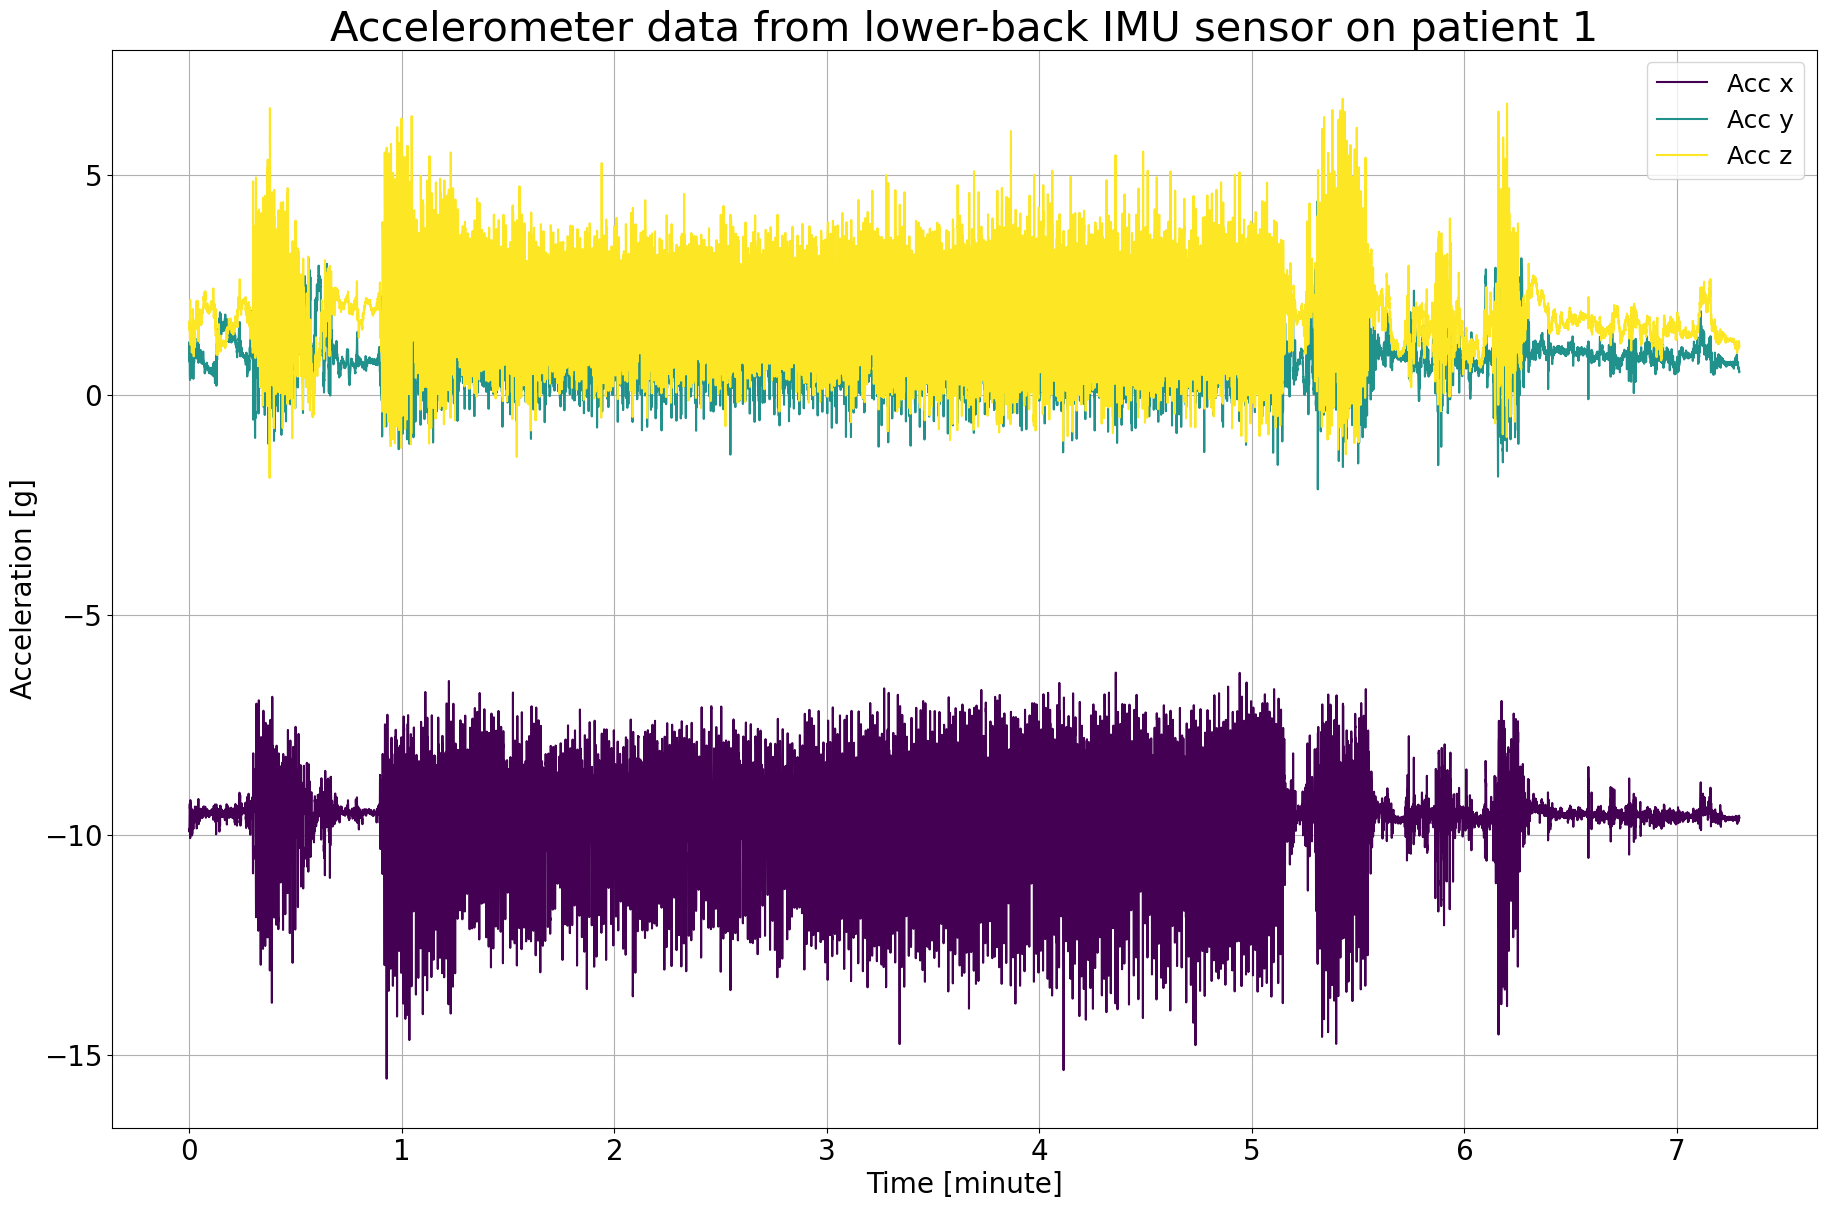

In [19]:
# Calculate the time values in minutes
# The 'time_in_minute' array represents time values in minutes, computed based on the length of 'acceleration_data' and 'sampling_frequency'.
time_in_minute = np.arange(len(acceldata)) / (60 * sampling_frequency)

# Create a figure with a specified size
plt.figure(figsize=(22, 14))

# Get colors for raw
colors = cfg_colors["raw"]

# A loop is used to plot data for each accelerometer axis, applying different colors from the color map.
for i in range(3):
    plt.plot(
        time_in_minute,
        acceldata[f"Accelerometer_{chr(120 + i).upper()}"],
        color=colors[i],
        label=f"Acc {'xyz'[i]}",
    )

# Add labels and legends
plt.xlabel("Time [minute]", fontsize=20)
plt.ylabel("Acceleration [g]", fontsize=20)
plt.legend(fontsize=18)

# Add a title with a specified font size
plt.title(
    "Accelerometer data from lower-back IMU sensor on patient 1",
    fontsize=30,
)

# Customize tick font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Display a grid for reference
plt.grid(visible=None, which="both", axis="both")

# Show the plot
plt.show()

### Zooming in on a time range

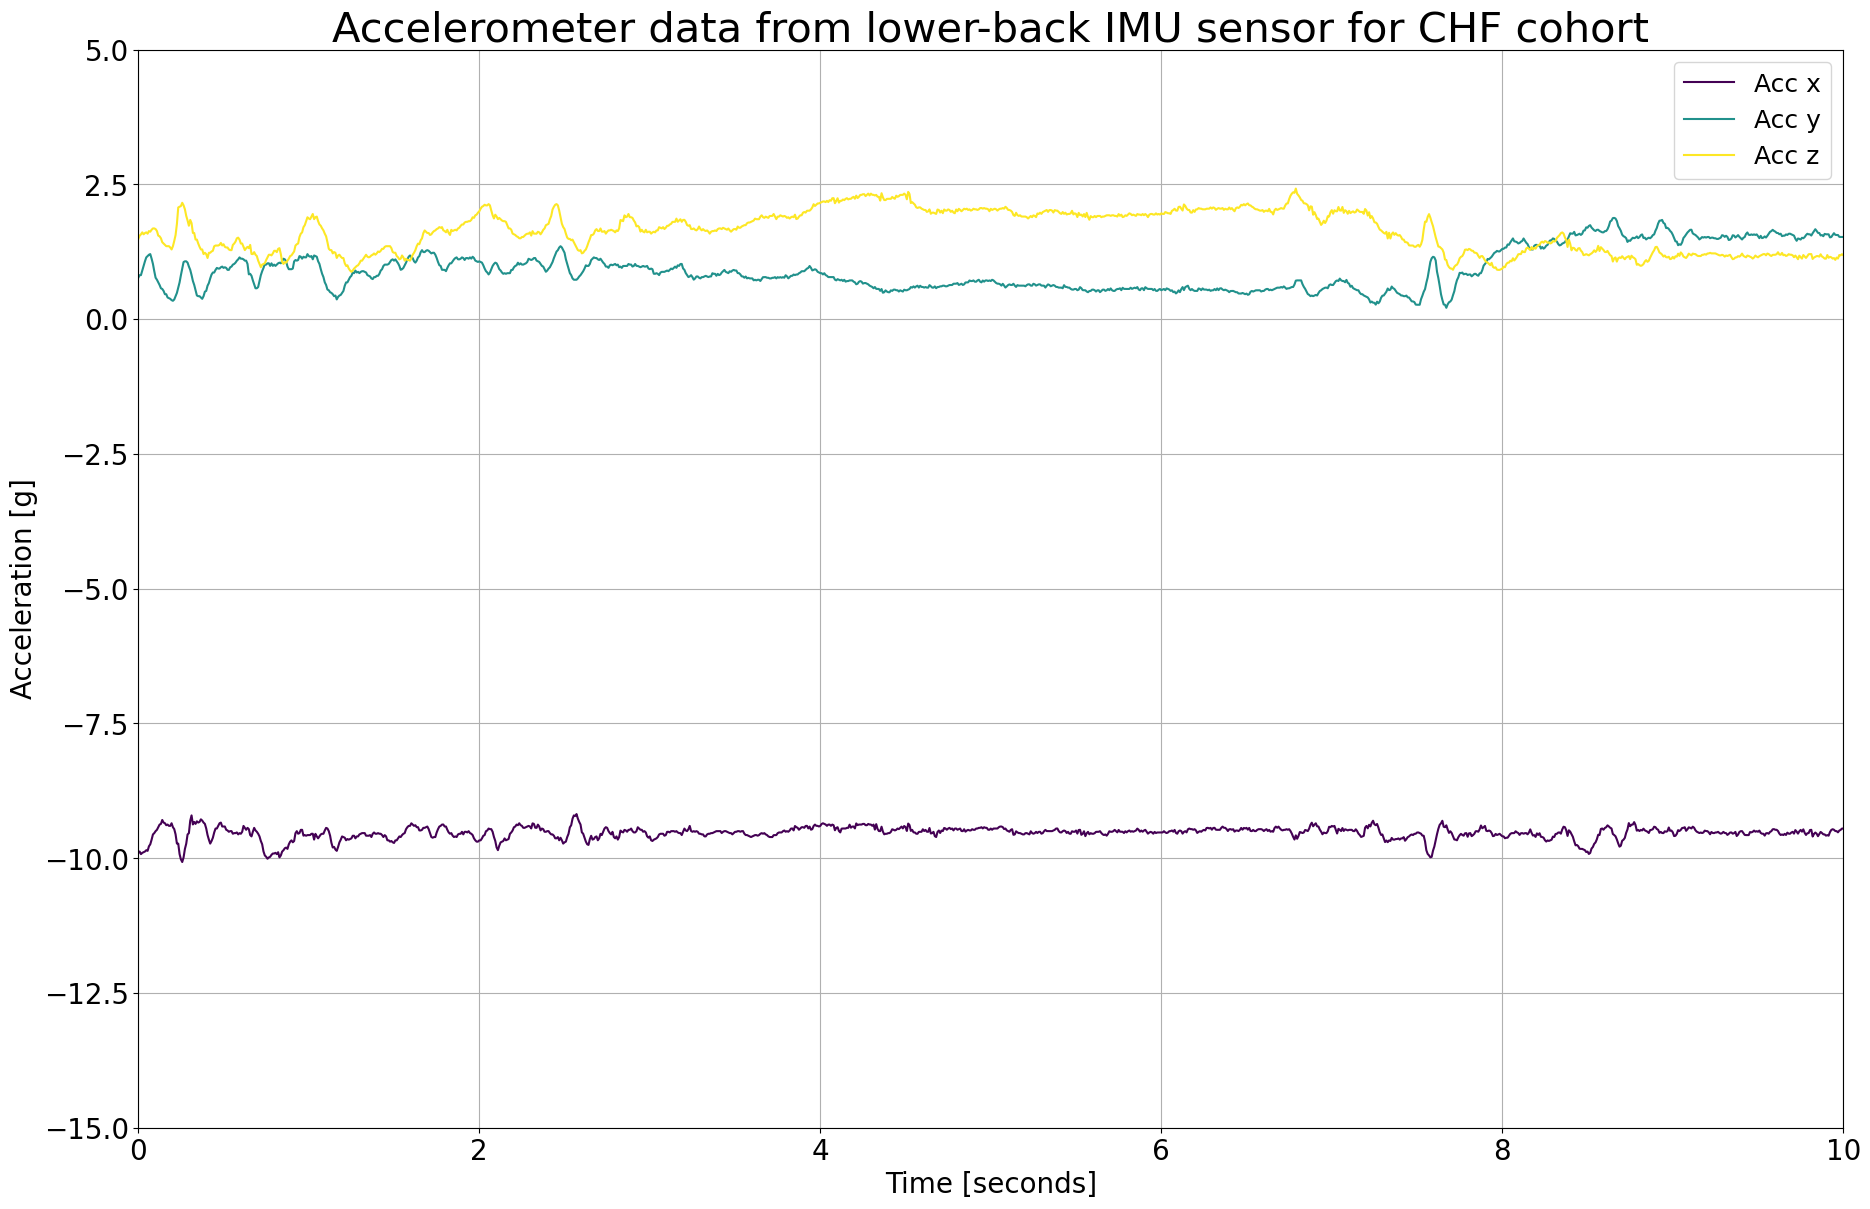

In [20]:
# Calculate the time values based on the length of the data
num_samples = len(acceldata)
time_seconds = np.arange(num_samples) / sampling_frequency

# Create a figure with the specified size
plt.figure(figsize=(22, 14))

# Plot acceleration data for each axis with time on the x-axis
for i in range(3):
    plt.plot(
        time_seconds,
        acceldata[f"Accelerometer_{chr(120 + i).upper()}"],
        color=colors[i],
        label=f"Acc {'xyz'[i]}",
    )

# Add labels and legends
plt.xlabel("Time [seconds]", fontsize=20)
plt.ylabel("Acceleration [g]", fontsize=20)
plt.legend(fontsize=18)

# Add a title
plt.title(
    "Accelerometer data from lower-back IMU sensor for CHF cohort",
    fontsize=30,
)

# Customize font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Set x-axis and y-axis limits for a specific duration (in seconds) and acceleration range
plt.xlim(0, 10)
plt.ylim(-15, 5)

# Display a grid for reference
plt.grid(visible=None, which="both", axis="both")

# Show the plot
plt.show()

## Gait Sequence Detection

7 gait sequence(s) detected.


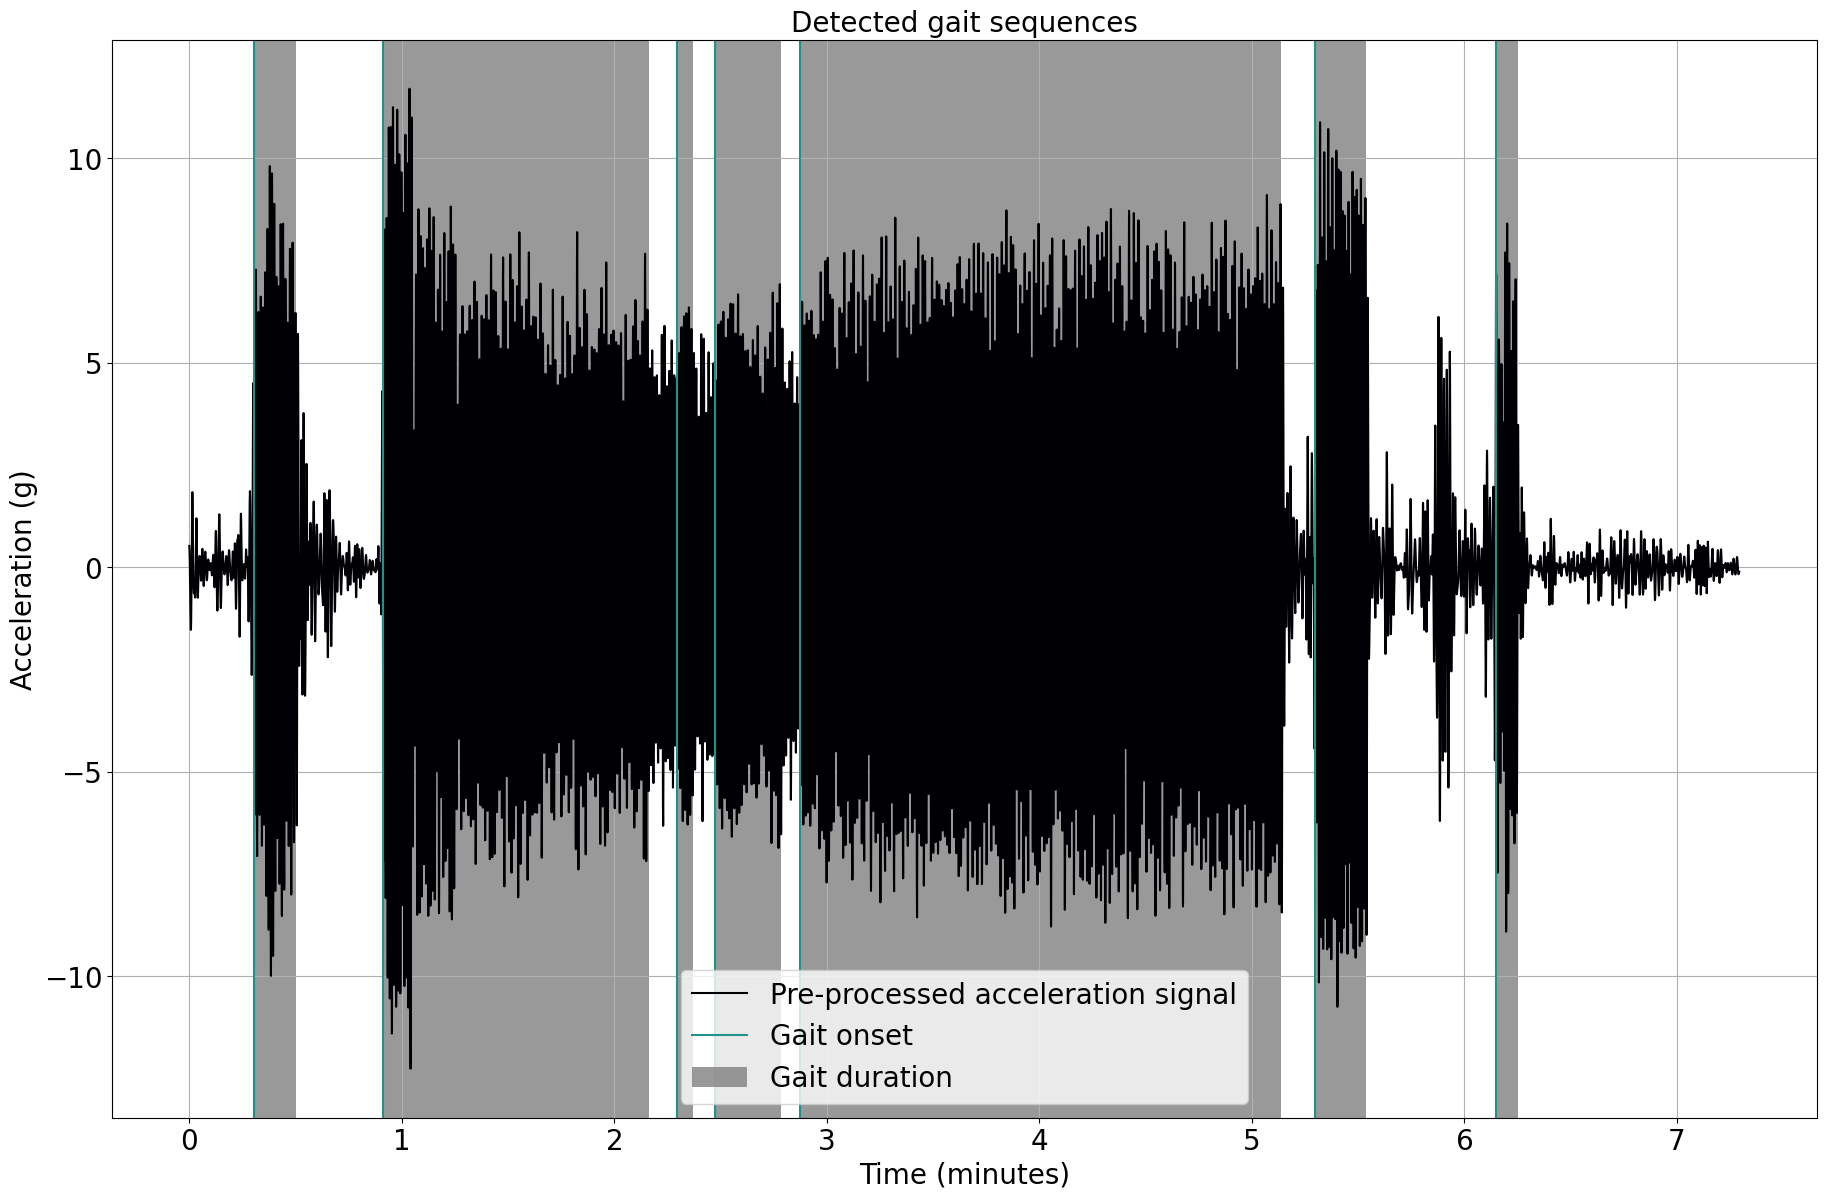

   Event Number    onset  duration     event_type tracking_system
0             1   18.325    11.725  gait sequence             IMU
1             2   54.625    75.250  gait sequence             IMU
2             3  137.800     4.475  gait sequence             IMU
3             4  148.450    18.525  gait sequence             IMU
4             5  172.525   135.725  gait sequence             IMU
5             6  317.875    14.275  gait sequence             IMU
6             7  368.800     6.175  gait sequence             IMU


In [21]:
# Create an instance of the ParaschivIonescuGaitSequenceDetection class
gsd = ParaschivIonescuGaitSequenceDetection()

# Call the gait sequence detection using gsd.detect
gsd = gsd.detect(
    data=acceldata, sampling_freq_Hz=sampling_frequency, plot_results=True, dt_data=None
)

# Gait sequences are stored in gait_sequences_ attribute of gsd
gait_sequences = gsd.gait_sequences_

# Add events to the recording as a dictionary including tracking system and events
gait_sequence_events = gait_sequences

# Show events and their corresponding information
df = pd.DataFrame(gait_sequence_events)

# Add a new column "Event Number" with incremental numbers starting from 1
df.insert(0, 'Event Number', range(1, len(df) + 1))

# Update the "tracking_system" column to "IMU"
df['tracking_system'] = 'IMU'

# Display the updated DataFrame
print(df)

## Focus on a specific sequence

First gait sequence:
 onset                     18.325
duration                  11.725
event_type         gait sequence
tracking_system             None
Name: 0, dtype: object


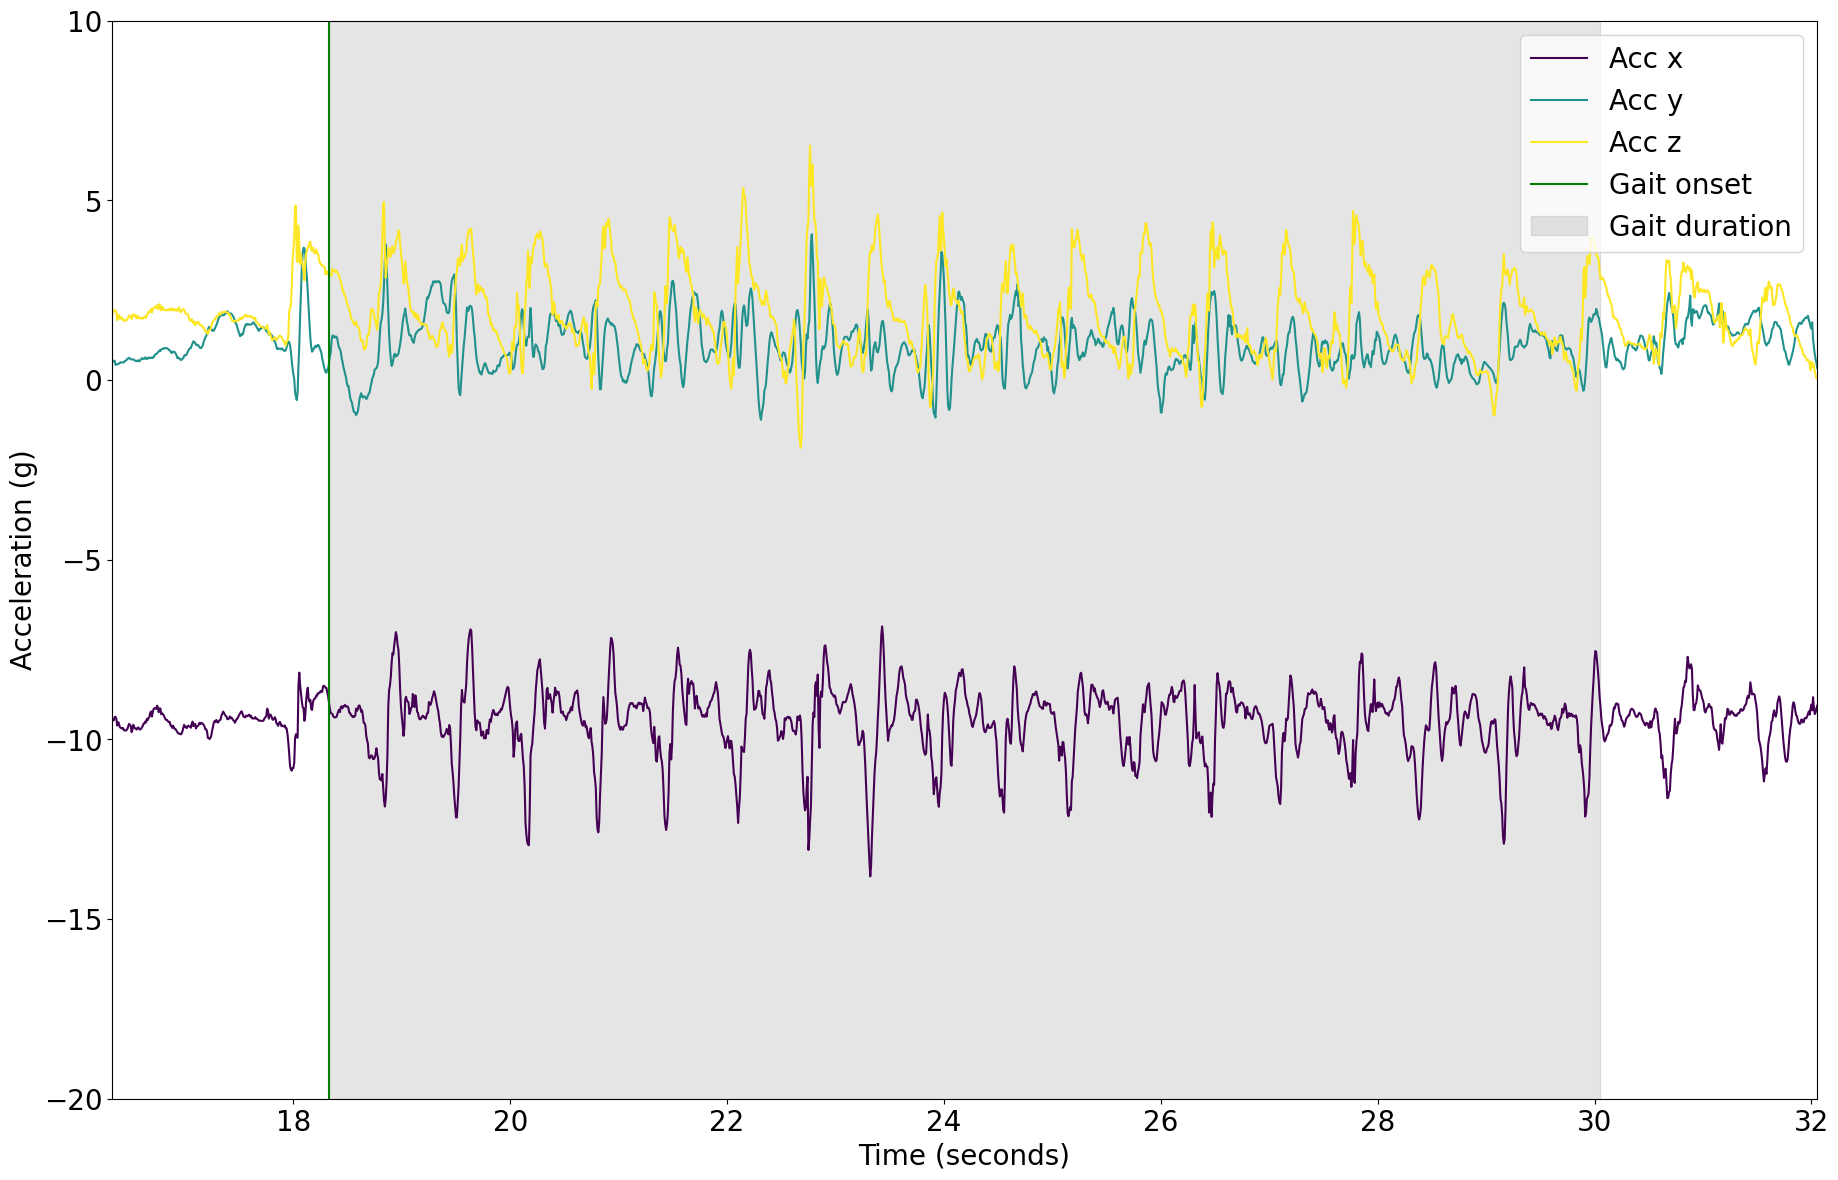

In [22]:

# Access and print first detected gait sequence
first_gait_sequence = gait_sequence_events.iloc[0]
print("First gait sequence:\n", first_gait_sequence)

# Plot the raw data from the lower back
fig, ax = plt.subplots(figsize=(22, 14))

# Plot raw acceleration data
for i in range(3):
    ax.plot(
        time_seconds,
        acceldata[f"Accelerometer_{chr(120 + i).upper()}"],
        color=colors[i],
        label=f"Acc {'xyz'[i]}",
    )

# Plot the first element of gait sequences
plt.axvline(first_gait_sequence["onset"], color="g", label="Gait onset")
ax.axvspan(
    first_gait_sequence["onset"],
    first_gait_sequence["onset"] + first_gait_sequence["duration"],
    alpha=0.2,
    color="gray",
    label="Gait duration",
)

# Customize plot
start_limit = first_gait_sequence["onset"] - 2
end_limit = first_gait_sequence["onset"] + first_gait_sequence["duration"] + 2
ax.set_xlim(start_limit, end_limit)
ax.set_ylim(-20, 10)
ax.set_xlabel("Time (seconds)", fontsize=20)
ax.set_ylabel("Acceleration (g)", fontsize=20)
ax.legend(loc="upper right", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()